In [1]:
# *------- Basic setup -------*
import numpy as np
import pandas as pd
import os, random, time
import copy
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from PIL import Image

# *------- torch -------*
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
#import torchvision.transforms as transforms
from torchsummary import summary

# *------- albumentations -------*
#!pip install albumentations==1.0.3
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# *------- sklearn -------*
from sklearn.model_selection import train_test_split

# *------- path -------*
base_path = "./"

# test 폴더를 한 단계 상위 폴더로 옮겨서 사용했습니다.
# 옮기지 않은 경우
#test_path = os.path.join(base_path, "test","test")
test_path = os.path.join(base_path, "test")
train_path = os.path.join(base_path, "train")

### Reference

algumentation : https://dacon.io/competitions/official/235838/codeshare/3734?page=1&dtype=recent
pseudo_labeling : https://github.com/anirudhshenoy/pseudo_labeling_small_datasets/blob/master/pseudo_label-DL.ipynb
Model : https://deep-learning-study.tistory.com/563
LrSceduler,Early Stopping : https://dacon.io/competitions/official/235838/codeshare/3778?page=1&dtype=recent

In [2]:
import cv2

In [113]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(1010)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
IMG_SIZE = (28,28)
BATCH_SIZE = 32
ULBATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_CLASSES = 10


In [114]:
def get_train_transforms():
    return A.Compose([
        A.OneOf([A.Rotate(limit=25,interpolation=cv2.INTER_NEAREST),
                 A.RandomResizedCrop(height=28,width=28,scale=(.35, 1.),ratio=(.5, 2),
                        interpolation=cv2.INTER_NEAREST)]),
    ToTensorV2(p=1.0),])
def get_valid_transforms():
    return A.Compose([ToTensorV2(p=1.0)])

def get_inferecne_transforms():
    return ToTensorV2(p=1.0)

In [115]:
class MnistDataset(Dataset):
    def __init__(self, X=None, y=None, transform=None):
        super().__init__()
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        image = Image.open(img_path)#.convert("RGB")
        image = np.array(image, dtype='float32')
        #img /= 255
        image = self.transform(image = image)['image']
        
        if self.y is not None:
            label = self.y[idx]
            label = torch.tensor(label, dtype=torch.int64)
            return image, label
        else:
            image = image.numpy()
            return torch.from_numpy(image).type(torch.FloatTensor)

In [116]:
tr_csv = pd.read_csv(os.path.join(base_path, "train","train_data.csv"))

tr_csv['path'] = tr_csv['filen_name'].apply(
    lambda x: os.path.join(train_path,x))


In [117]:
teach_csv = tr_csv.sample(replace=False,n=3000)
teach_index = teach_csv.index

In [118]:
tr_csv = tr_csv.drop(teach_index)

In [119]:
tr_csv

,filen_name,label,path
0,train0001.png,8,./train\train0001.png
2,train0003.png,8,./train\train0003.png
3,train0004.png,8,./train\train0004.png
8,train0009.png,8,./train\train0009.png
11,train0012.png,8,./train\train0012.png
...,...,...,...
4990,train4991.png,6,./train\train4991.png
4992,train4993.png,6,./train\train4993.png
4995,train4996.png,6,./train\train4996.png
4996,train4997.png,6,./train\train4997.png


In [120]:
train_x, valid_x, train_y, valid_y = train_test_split(
    tr_csv['path'].values, tr_csv["label"].values, test_size=0.5,shuffle=True)

In [121]:
train_x.shape, valid_x.shape, train_y.shape,valid_y.shape

((1000,), (1000,), (1000,), (1000,))

In [122]:
teach_x, teach_y = teach_csv['path'].values, teach_csv["label"].values

In [123]:
teach_x.shape

(3000,)

In [124]:
train_ds = MnistDataset(train_x, train_y, get_train_transforms())
valid_ds = MnistDataset(valid_x, valid_y, get_valid_transforms())
teach_ds = MnistDataset(teach_x,transform=get_train_transforms())
train_size = len(train_ds)
val_size = len(valid_ds)

train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size = BATCH_SIZE, shuffle=False)
teach_dl = DataLoader(teach_ds, batch_size = ULBATCH_SIZE, shuffle=False)

In [125]:
# rows = 2
# columns = 5
# plt.rcParams['figure.figsize'] = (15.0, 8.0)
# for idx in range(10) : 
#          # image index 
#     ttitle = "Image{}".format(idx+1 ) # image title
#     plt.subplot(rows, columns, idx+1) # subplot 
#     plt.title(ttitle)   # title 
#     # // plt.axis('off')
#     plt.xticks([])  # x = None 
#     plt.yticks([])  # y = None
#     plt.imshow(np.squeeze(transform(image=np.array(Image.open(train_x[idx]).convert("RGB"),dtype='float32'))['image']).permute(1,2,0)) 
# plt.show()


In [126]:
# rows = 2
# columns = 5
# plt.rcParams['figure.figsize'] = (15.0, 8.0)
# for idx in range(10) : 
#          # image index 
#     ttitle = "Image{}".format(idx+1 ) # image title
#     plt.subplot(rows, columns, idx+1) # subplot 
#     plt.title(ttitle)   # title 
#     # // plt.axis('off')
#     plt.xticks([])  # x = None 
#     plt.yticks([])  # y = None
#     plt.imshow(np.squeeze(transform(image=np.array(Image.open(train_x[idx]),dtype='float32'))['image'])) 
# plt.show()


In [127]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, 3) # 합성곱 연산 (입력 채널 수: 3, 출력 채널 수: 6, 필터 크기: 5x5, stride=1(default))
#         self.pool1 = nn.MaxPool2d(2,2) # 합성곱 연산 (필터크기 2x2, stride=2)
#         self.conv2 = nn.Conv2d(16, 16, 3) # 합성곱 연산 (입력 채널 수: 6, 출력 채널수: 16, 필터 크기: 5x5, stride=1(default))
#         self.pool2 = nn.MaxPool2d(2, 2) # 합성곱 연산 (필터크기 2x2, stride=2)
#         self.fc1 = nn.Linear(400,100) # 5x5 피쳐맵 16개를 일렬로 피면 16*5*5개의 노드가 생성됨.
#         self.fc2 = nn.Linear(100, 10)

#     def forward(self, x):
#         x = self.pool1(F.relu(self.conv1(x))) # conv1 -> ReLU -> pool
#         #print(x.shape)
#         x = self.pool2(F.relu(self.conv2(x))) # conv2 -> ReLU -> pool2
#         #print(x.shape)
#         x = x.view(-1, 16*5*5) # 5x5 피쳐맵 16개를 일렬로 만든다.
#         #print(x.shape)
#         x = F.relu(self.fc1(x))
#         #print(x.shape)
#         x = F.relu(self.fc2(x))
#         return x
# net = Net().to(DEVICE)

In [137]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.inputs = nn.Conv2d(1,3,kernel_size=(1,1)) # 흑백 -> 3차원
        self.model = torchvision.models.resnet34(pretrained = False) # 사전학습 x 구조만 load
        self.drop = nn.Dropout(0.5)
        self.fc = nn.Linear(1000,10) # 0~9 
    def forward(self, x, softmax=True):
        x = self.inputs(x)
        x = self.model(x)
        x = self.drop(x)
        x = self.fc(x)
        if softmax:
            x = F.softmax(x,dim=1)
        return x

In [138]:
import torch.optim as optim
net = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss() # LogSoftmax + NLLLoss 다중분류
optimizer = optim.Adam(net.parameters(), lr=1e-5)
net.to(DEVICE)
param = list(net.parameters())
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                                    lr_lambda=lambda epoch: 0.95 ** epoch,
                                                    last_epoch=-1,
                                                    verbose=False)

In [139]:
class EarlyStopping:
    # 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', k_num=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.k_num = k_num
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
#             print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.val_loss_min = val_loss

In [140]:
def evaluate(model, test_loader,criterion):
    model.eval()
    correct = 0 
    loss = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.cuda()
            output = model(data)
            predicted = torch.max(output,1)[1]
            correct += (predicted == labels.cuda()).sum()
            loss += criterion(output, labels.cuda()).item()

    return (float(correct)/len(valid_ds)) *100, (loss/len(test_loader))

In [141]:
from tqdm import tqdm_notebook
# normal train
def train_supervised(model,optimizer,crtierion, train_loader, test_loader):
    EPOCHS = 3000
    early_stopping = EarlyStopping(patience = 100, verbose = True)
    model.train()
    for epoch in tqdm_notebook(range(EPOCHS)):
        correct = 0
        running_loss = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            output = model(X_batch)
            labeled_loss = criterion(output, y_batch)
                       
            optimizer.zero_grad()
            labeled_loss.backward()
            optimizer.step()
            running_loss += labeled_loss.item()
        scheduler.step()
        if epoch %10 == 0:
            test_acc, test_loss = evaluate(model, test_loader,criterion)
            print('Epoch: {} : Train Loss : {:.5f} | Test Acc : {:.5f} | Test Loss : {:.3f} '.format(epoch, running_loss/(10 * len(train_ds)), test_acc, test_loss))
            model.train()
            early_stopping(float(test_loss), model)
        if early_stopping.early_stop:
            print("Early stopping!!")
            break            
            
train_supervised(net,optimizer,criterion, train_dl, valid_dl)

<ipython-input-141-362a27537fd9>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(EPOCHS)):


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 0 : Train Loss : 0.00737 | Test Acc : 14.80000 | Test Loss : 2.297 
Validation loss decreased (inf --> 2.296604).  Saving model ...
Epoch: 10 : Train Loss : 0.00656 | Test Acc : 42.00000 | Test Loss : 2.046 
Validation loss decreased (2.296604 --> 2.045809).  Saving model ...
Epoch: 20 : Train Loss : 0.00624 | Test Acc : 52.50000 | Test Loss : 1.947 
Validation loss decreased (2.045809 --> 1.946899).  Saving model ...
Epoch: 30 : Train Loss : 0.00607 | Test Acc : 62.40000 | Test Loss : 1.886 
Validation loss decreased (1.946899 --> 1.885909).  Saving model ...
Epoch: 40 : Train Loss : 0.00595 | Test Acc : 68.60000 | Test Loss : 1.833 
Validation loss decreased (1.885909 --> 1.833176).  Saving model ...
Epoch: 50 : Train Loss : 0.00587 | Test Acc : 71.70000 | Test Loss : 1.811 
Validation loss decreased (1.833176 --> 1.811416).  Saving model ...
Epoch: 60 : Train Loss : 0.00581 | Test Acc : 73.50000 | Test Loss : 1.795 
Validation loss decreased (1.811416 --> 1.794703).  Saving m

Epoch: 940 : Train Loss : 0.00576 | Test Acc : 76.50000 | Test Loss : 1.776 
Epoch: 950 : Train Loss : 0.00584 | Test Acc : 76.40000 | Test Loss : 1.773 
Epoch: 960 : Train Loss : 0.00574 | Test Acc : 75.90000 | Test Loss : 1.779 
Epoch: 970 : Train Loss : 0.00575 | Test Acc : 76.30000 | Test Loss : 1.776 
Epoch: 980 : Train Loss : 0.00581 | Test Acc : 77.50000 | Test Loss : 1.769 
Epoch: 990 : Train Loss : 0.00580 | Test Acc : 77.10000 | Test Loss : 1.776 
Epoch: 1000 : Train Loss : 0.00579 | Test Acc : 77.50000 | Test Loss : 1.771 
Epoch: 1010 : Train Loss : 0.00584 | Test Acc : 76.90000 | Test Loss : 1.776 
Epoch: 1020 : Train Loss : 0.00578 | Test Acc : 77.30000 | Test Loss : 1.768 
Epoch: 1030 : Train Loss : 0.00581 | Test Acc : 75.40000 | Test Loss : 1.775 
Epoch: 1040 : Train Loss : 0.00581 | Test Acc : 76.00000 | Test Loss : 1.778 
Epoch: 1050 : Train Loss : 0.00582 | Test Acc : 76.80000 | Test Loss : 1.771 
Epoch: 1060 : Train Loss : 0.00575 | Test Acc : 75.70000 | Test Loss :

In [142]:
test_acc, test_loss = evaluate(net, valid_dl,criterion)
print('Test Acc : {:.5f} | Test Loss : {:.3f} '.format(test_acc, test_loss))

Test Acc : 78.20000 | Test Loss : 1.775 


In [143]:
T1 = 100 # HyperParameter 
T2 = 700
af = 3

def alpha_weight(epoch):
    if epoch < T1:
        return 0.0
    elif epoch > T2:
        return af
    else:
         return ((epoch-T1) / (T2-T1))*af

In [144]:
#Psuedo Labeling 
acc_scores = []
unlabel = []
pseudo_label = []

alpha_log = []
test_acc_log = []
test_loss_log = []
def semisup_train(model,optimizer,criterion, train_loader, unlabeled_loader, test_loader):
    EPOCHS = 2000
    early_stopping = EarlyStopping(patience = 100, verbose = True)
    # 기본 Epoch를 사용하는 대신 a_weight를 계산하기 위해 step 변수 사용
    # 따라서 모델이 더 빠르게 수렴함
    step = 1000 
    
    model.train()
    for epoch in tqdm_notebook(range(EPOCHS)):
        for batch_idx, x_unlabeled in enumerate(unlabeled_loader):
            
            
            # pseudo label을 가져오기 위해 forward pass
            x_unlabeled = x_unlabeled.cuda()
            model.eval()
            output_unlabeled = model(x_unlabeled)
            _, pseudo_labeled = torch.max(output_unlabeled, 1)
            model.train()
             """ ONLY FOR VISUALIZATION"""
            if (batch_idx < 3) and (epoch % 10 == 0):
                unlabel.append(x_unlabeled.cpu())
                pseudo_label.append(pseudo_labeled.cpu())
                 """ ********************** """
            
            # pseudo label 을 사용하여 레이블이 지정되지 않은 손실을 계산
            output = model(x_unlabeled)
            unlabeled_loss = alpha_weight(step) * criterion(output, pseudo_labeled)   
            
            # 역전파
            optimizer.zero_grad()
            unlabeled_loss.backward()
            optimizer.step()
            
            
            # 50개 배치마다 레이블이 지정된 데이터에 대해 한단계씩 학습함
            if batch_idx % 50 == 0:
                
                # Normal training procedure
                for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                    X_batch = X_batch.cuda()
                    y_batch = y_batch.cuda()
                    output = model(X_batch)
                    labeled_loss = criterion(output, y_batch)

                    optimizer.zero_grad()
                    labeled_loss.backward()
                    optimizer.step()
                
                # Now we increment step by 1
                step += 1
                

        test_acc, test_loss =evaluate(model, test_loader,criterion)
        early_stopping(float(test_loss), model)
        if early_stopping.early_stop:
            print("Early stopping!!")
            break            
            print('Epoch: {} : Train Loss : {:.5f} | Test Acc : {:.5f} | Test Loss : {:.3f} '.format(epoch, running_loss/(10 * len(train_ds)), test_acc, test_loss))
            model.train()
        print('Epoch: {} : Alpha Weight : {:.5f} | Test Acc : {:.5f} | Test Loss : {:.3f} '.format(epoch, alpha_weight(step), test_acc, test_loss))
        
        """ LOGGING VALUES """
        alpha_log.append(alpha_weight(step))
        test_acc_log.append(test_acc/100)
        test_loss_log.append(test_loss)
        """ ************** """
        model.train()
 

IndentationError: unexpected indent (<ipython-input-144-a4968f53b0c2>, line 27)

In [145]:
semisup_train(net,optimizer,criterion, train_dl, teach_dl,valid_dl)

<ipython-input-70-933b17ad1071>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(EPOCHS)):


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.769 
Epoch: 1 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 2 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.769 
Epoch: 3 : Alpha Weight : 3.00000 | Test Acc : 76.00000 | Test Loss : 1.771 
Epoch: 4 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.770 
Epoch: 5 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 6 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.771 
Epoch: 7 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.770 
Epoch: 8 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.768 
Epoch: 9 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.769 
Epoch: 10 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.771 
Epoch: 11 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.769 
Epoch: 12 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.7

Epoch: 106 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.769 
Epoch: 107 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.771 
Epoch: 108 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.771 
Epoch: 109 : Alpha Weight : 3.00000 | Test Acc : 76.80000 | Test Loss : 1.769 
Epoch: 110 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.769 
Epoch: 111 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.771 
Epoch: 112 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.769 
Epoch: 113 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.773 
Epoch: 114 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.770 
Epoch: 115 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.769 
Epoch: 116 : Alpha Weight : 3.00000 | Test Acc : 76.00000 | Test Loss : 1.769 
Epoch: 117 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.771 
Epoch: 118 : Alpha Weight : 3.00000 | Test Acc : 77.

Epoch: 210 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.773 
Epoch: 211 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.770 
Epoch: 212 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.770 
Epoch: 213 : Alpha Weight : 3.00000 | Test Acc : 76.90000 | Test Loss : 1.770 
Epoch: 214 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.770 
Epoch: 215 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.771 
Epoch: 216 : Alpha Weight : 3.00000 | Test Acc : 76.00000 | Test Loss : 1.772 
Epoch: 217 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.771 
Epoch: 218 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.768 
Epoch: 219 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.772 
Epoch: 220 : Alpha Weight : 3.00000 | Test Acc : 77.00000 | Test Loss : 1.769 
Epoch: 221 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 222 : Alpha Weight : 3.00000 | Test Acc : 76.

Epoch: 314 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.771 
Epoch: 315 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.769 
Epoch: 316 : Alpha Weight : 3.00000 | Test Acc : 76.00000 | Test Loss : 1.769 
Epoch: 317 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 318 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.770 
Epoch: 319 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.770 
Epoch: 320 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.769 
Epoch: 321 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.771 
Epoch: 322 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 323 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.770 
Epoch: 324 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.769 
Epoch: 325 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 326 : Alpha Weight : 3.00000 | Test Acc : 76.

Epoch: 418 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.769 
Epoch: 419 : Alpha Weight : 3.00000 | Test Acc : 76.90000 | Test Loss : 1.770 
Epoch: 420 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.769 
Epoch: 421 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 422 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.769 
Epoch: 423 : Alpha Weight : 3.00000 | Test Acc : 76.90000 | Test Loss : 1.771 
Epoch: 424 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.770 
Epoch: 425 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.770 
Epoch: 426 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.769 
Epoch: 427 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.768 
Epoch: 428 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.772 
Epoch: 429 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.771 
Epoch: 430 : Alpha Weight : 3.00000 | Test Acc : 76.

Epoch: 522 : Alpha Weight : 3.00000 | Test Acc : 77.00000 | Test Loss : 1.769 
Epoch: 523 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.771 
Epoch: 524 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 525 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.769 
Epoch: 526 : Alpha Weight : 3.00000 | Test Acc : 75.90000 | Test Loss : 1.770 
Epoch: 527 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.769 
Epoch: 528 : Alpha Weight : 3.00000 | Test Acc : 76.80000 | Test Loss : 1.769 
Epoch: 529 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.770 
Epoch: 530 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.770 
Epoch: 531 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.770 
Epoch: 532 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.771 
Epoch: 533 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.769 
Epoch: 534 : Alpha Weight : 3.00000 | Test Acc : 76.

Epoch: 626 : Alpha Weight : 3.00000 | Test Acc : 76.00000 | Test Loss : 1.771 
Epoch: 627 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.771 
Epoch: 628 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.772 
Epoch: 629 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.769 
Epoch: 630 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.769 
Epoch: 631 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.770 
Epoch: 632 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 633 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 634 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.773 
Epoch: 635 : Alpha Weight : 3.00000 | Test Acc : 75.70000 | Test Loss : 1.770 
Epoch: 636 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.771 
Epoch: 637 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.770 
Epoch: 638 : Alpha Weight : 3.00000 | Test Acc : 76.

Epoch: 730 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.770 
Epoch: 731 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.771 
Epoch: 732 : Alpha Weight : 3.00000 | Test Acc : 77.20000 | Test Loss : 1.770 
Epoch: 733 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.770 
Epoch: 734 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.770 
Epoch: 735 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.771 
Epoch: 736 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.770 
Epoch: 737 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.769 
Epoch: 738 : Alpha Weight : 3.00000 | Test Acc : 76.00000 | Test Loss : 1.772 
Epoch: 739 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 740 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.771 
Epoch: 741 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.770 
Epoch: 742 : Alpha Weight : 3.00000 | Test Acc : 76.

Epoch: 834 : Alpha Weight : 3.00000 | Test Acc : 76.00000 | Test Loss : 1.773 
Epoch: 835 : Alpha Weight : 3.00000 | Test Acc : 76.00000 | Test Loss : 1.771 
Epoch: 836 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.769 
Epoch: 837 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 838 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.771 
Epoch: 839 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.770 
Epoch: 840 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 841 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 842 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.772 
Epoch: 843 : Alpha Weight : 3.00000 | Test Acc : 76.80000 | Test Loss : 1.772 
Epoch: 844 : Alpha Weight : 3.00000 | Test Acc : 75.90000 | Test Loss : 1.771 
Epoch: 845 : Alpha Weight : 3.00000 | Test Acc : 76.00000 | Test Loss : 1.769 
Epoch: 846 : Alpha Weight : 3.00000 | Test Acc : 76.

Epoch: 938 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.771 
Epoch: 939 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 940 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 941 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 942 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.769 
Epoch: 943 : Alpha Weight : 3.00000 | Test Acc : 76.00000 | Test Loss : 1.771 
Epoch: 944 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.771 
Epoch: 945 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.769 
Epoch: 946 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.769 
Epoch: 947 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.770 
Epoch: 948 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.770 
Epoch: 949 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 950 : Alpha Weight : 3.00000 | Test Acc : 76.

Epoch: 1042 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 1043 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 1044 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.772 
Epoch: 1045 : Alpha Weight : 3.00000 | Test Acc : 76.80000 | Test Loss : 1.771 
Epoch: 1046 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 1047 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.772 
Epoch: 1048 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 1049 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.771 
Epoch: 1050 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.771 
Epoch: 1051 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.771 
Epoch: 1052 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.770 
Epoch: 1053 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.772 
Epoch: 1054 : Alpha Weight : 3.00000 | T

Epoch: 1145 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.771 
Epoch: 1146 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.770 
Epoch: 1147 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.769 
Epoch: 1148 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.771 
Epoch: 1149 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.770 
Epoch: 1150 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.768 
Epoch: 1151 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 1152 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 1153 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.771 
Epoch: 1154 : Alpha Weight : 3.00000 | Test Acc : 76.80000 | Test Loss : 1.768 
Epoch: 1155 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 1156 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.770 
Epoch: 1157 : Alpha Weight : 3.00000 | T

Epoch: 1248 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 1249 : Alpha Weight : 3.00000 | Test Acc : 76.80000 | Test Loss : 1.770 
Epoch: 1250 : Alpha Weight : 3.00000 | Test Acc : 76.00000 | Test Loss : 1.770 
Epoch: 1251 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 1252 : Alpha Weight : 3.00000 | Test Acc : 76.80000 | Test Loss : 1.771 
Epoch: 1253 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.772 
Epoch: 1254 : Alpha Weight : 3.00000 | Test Acc : 75.90000 | Test Loss : 1.769 
Epoch: 1255 : Alpha Weight : 3.00000 | Test Acc : 77.10000 | Test Loss : 1.769 
Epoch: 1256 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.771 
Epoch: 1257 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.770 
Epoch: 1258 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.772 
Epoch: 1259 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.769 
Epoch: 1260 : Alpha Weight : 3.00000 | T

Epoch: 1351 : Alpha Weight : 3.00000 | Test Acc : 75.80000 | Test Loss : 1.771 
Epoch: 1352 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.771 
Epoch: 1353 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.772 
Epoch: 1354 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.769 
Epoch: 1355 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 1356 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.771 
Epoch: 1357 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.770 
Epoch: 1358 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 1359 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 1360 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.770 
Epoch: 1361 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.770 
Epoch: 1362 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 1363 : Alpha Weight : 3.00000 | T

Epoch: 1454 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 1455 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.771 
Epoch: 1456 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.770 
Epoch: 1457 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.769 
Epoch: 1458 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.771 
Epoch: 1459 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.770 
Epoch: 1460 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.770 
Epoch: 1461 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.769 
Epoch: 1462 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.771 
Epoch: 1463 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.769 
Epoch: 1464 : Alpha Weight : 3.00000 | Test Acc : 76.80000 | Test Loss : 1.771 
Epoch: 1465 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.771 
Epoch: 1466 : Alpha Weight : 3.00000 | T

Epoch: 1557 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 1558 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.769 
Epoch: 1559 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.770 
Epoch: 1560 : Alpha Weight : 3.00000 | Test Acc : 76.00000 | Test Loss : 1.771 
Epoch: 1561 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.769 
Epoch: 1562 : Alpha Weight : 3.00000 | Test Acc : 76.80000 | Test Loss : 1.770 
Epoch: 1563 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.770 
Epoch: 1564 : Alpha Weight : 3.00000 | Test Acc : 76.80000 | Test Loss : 1.770 
Epoch: 1565 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 1566 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 1567 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.769 
Epoch: 1568 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.770 
Epoch: 1569 : Alpha Weight : 3.00000 | T

Epoch: 1660 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.770 
Epoch: 1661 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.769 
Epoch: 1662 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.769 
Epoch: 1663 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 1664 : Alpha Weight : 3.00000 | Test Acc : 77.10000 | Test Loss : 1.768 
Epoch: 1665 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.769 
Epoch: 1666 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.771 
Epoch: 1667 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.771 
Epoch: 1668 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.772 
Epoch: 1669 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.771 
Epoch: 1670 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.770 
Epoch: 1671 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.772 
Epoch: 1672 : Alpha Weight : 3.00000 | T

Epoch: 1763 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.770 
Epoch: 1764 : Alpha Weight : 3.00000 | Test Acc : 76.80000 | Test Loss : 1.771 
Epoch: 1765 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.769 
Epoch: 1766 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.770 
Epoch: 1767 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.772 
Epoch: 1768 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.771 
Epoch: 1769 : Alpha Weight : 3.00000 | Test Acc : 75.90000 | Test Loss : 1.770 
Epoch: 1770 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.772 
Epoch: 1771 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.770 
Epoch: 1772 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.772 
Epoch: 1773 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 1774 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.770 
Epoch: 1775 : Alpha Weight : 3.00000 | T

Epoch: 1866 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 1867 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 1868 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 1869 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.769 
Epoch: 1870 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 1871 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.767 
Epoch: 1872 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 1873 : Alpha Weight : 3.00000 | Test Acc : 76.60000 | Test Loss : 1.771 
Epoch: 1874 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.771 
Epoch: 1875 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 1876 : Alpha Weight : 3.00000 | Test Acc : 76.30000 | Test Loss : 1.769 
Epoch: 1877 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.769 
Epoch: 1878 : Alpha Weight : 3.00000 | T

Epoch: 1969 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.768 
Epoch: 1970 : Alpha Weight : 3.00000 | Test Acc : 76.70000 | Test Loss : 1.769 
Epoch: 1971 : Alpha Weight : 3.00000 | Test Acc : 76.80000 | Test Loss : 1.768 
Epoch: 1972 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.770 
Epoch: 1973 : Alpha Weight : 3.00000 | Test Acc : 76.10000 | Test Loss : 1.770 
Epoch: 1974 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.769 
Epoch: 1975 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.771 
Epoch: 1976 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.771 
Epoch: 1977 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.771 
Epoch: 1978 : Alpha Weight : 3.00000 | Test Acc : 76.50000 | Test Loss : 1.771 
Epoch: 1979 : Alpha Weight : 3.00000 | Test Acc : 76.40000 | Test Loss : 1.770 
Epoch: 1980 : Alpha Weight : 3.00000 | Test Acc : 76.20000 | Test Loss : 1.769 
Epoch: 1981 : Alpha Weight : 3.00000 | T

In [36]:
torch.save(net.state_dict(),'./resnet_size28_Model.pt')

In [ ]:
# def train_model(model, criterion, optimizer, num_epochs, train_loader,val_loader,teach_loader):
#     since = time.time()
#     best_model = copy.deepcopy(model.state_dict())
#     best_acc = 0.0
    
#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        
#         # train
#         model.train()
#         running_loss = 0.0
#         running_corrects = 0

        
#         for step, (inputs, labels) in tqdm(enumerate(train_loader)):
#             inputs = inputs.to(DEVICE)
#             labels = labels.to(DEVICE)
#             optimizer.zero_grad()
#             with torch.set_grad_enabled(True):
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)
#         epoch_loss = running_loss / train_size
#         epoch_acc = running_corrects.double() / train_size
#         print('Train Loss: {:.4f} Train Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
#         # validate
#         model.eval()
#         running_loss = 0.0
#         running_corrects = 0
#         for inputs, labels in val_loader:
#             inputs = inputs.to(DEVICE)
#             labels = labels.to(DEVICE)
#             optimizer.zero_grad()
#             with torch.set_grad_enabled(False):
#                 outputs = model(inputs)
#                 _, preds = torch.max(outputs, 1)
#                 loss = criterion(outputs, labels) # labeld dataset
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)
#         epoch_loss = running_loss / val_size
#         epoch_acc = running_corrects.double() / val_size
#         print('Val Loss: {:.4f} Val Acc: {:.4f}'.format(epoch_loss, epoch_acc))
#         print('-' * 30)
#         if epoch_acc > best_acc:
#             best_acc = epoch_acc
#             best_model = copy.deepcopy(model.state_dict())
        
#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best Val Acc: {:.4f}'.format(best_acc))
#     model.load_state_dict(best_model)
#     return model

# # train the model
# model = train_model(net, criterion, optimizer, NUM_EPOCHS, train_dl, valid_dl)

In [72]:
ts_csv = pd.read_csv(os.path.join(base_path, "test","test_data.csv"))

ts_csv['path'] = ts_csv['file_name'].apply(
    lambda x: os.path.join(test_path, x))

test_x = ts_csv['path'].values
test_ds = MnistDataset(test_x, transform = get_inferecne_transforms())

test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle=False)

In [107]:
predictions = []

net.eval()
with torch.no_grad():
    for step, input in tqdm(enumerate(test_dl), total=len(test_dl)):
        input = input.to(DEVICE)
        y_pred = net(input).detach().cpu().numpy().argmax(axis=1).astype(int)
        
        predictions.extend(y_pred)

  0%|          | 0/157 [00:00<?, ?it/s]

In [75]:
submission = pd.read_csv('./sample_submission.csv') # sample submission 불러오기

submission['label'] = predictions

submission.to_csv('resnet_pseudo_argu_submission.csv', index=False)

In [ ]:
unlabel = np.concatenate([u.cpu().numpy() for u in teach_ds])
pseudo_label = np.concatenate([u.cpu().numpy() for u in pseudo_label])

In [ ]:
x = tr_csv = pd.read_csv(os.path.join(base_path, "train","train_data.csv"))
y = x['label']
x.drop(['label'], inplace = True, axis = 1)

x = normalizer.transform(x.values) # Image.open(test_x[idx]

tsne_x = np.concatenate([x, x_train, unlabel])
tsne_y = np.concatenate([y.values, y_train, pseudo_label])

embeddings = TSNE(perplexity = 30, n_jobs=-1, verbose = 1, n_iter = 500).fit_transform(tsne_x)

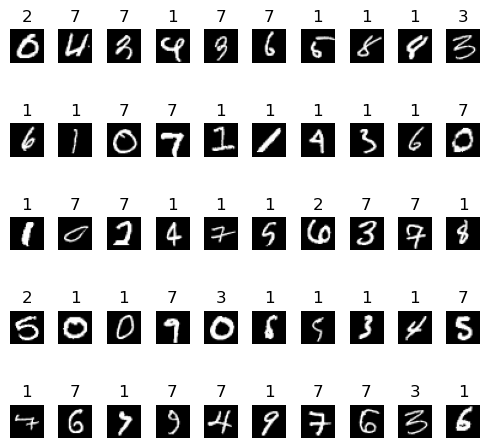

In [108]:
nrows, ncols = 5, 10

indices = np.random.randint(5000, size=(nrows, ncols))

indices = np.random.randint(5000, size=(nrows, ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, dpi=100, figsize=(5,5))
for i in range(nrows):
    for j in range(ncols):
        idx = indices[i][j]
        ax[i][j].imshow(Image.open(test_x[idx]), cmap='gray')
        ax[i][j].set_title(f"{predictions[idx]}")
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()